In [1]:
import quantumblur as qb
import map_Generator as mg
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, normalize, MinMaxScaler
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer,AdamOptimizer,MomentumOptimizer,QNGOptimizer
import seaborn as sns
import random
from countryinfo import CountryInfo
import os

In [2]:
def text2array(text):
    txt = open(text,"r")
    lines = txt.readlines()
    arr = []
    for line in lines:
        # print(line)
        tmp = []
        for c in line:
            if c == "#":
                tmp.append(1)
            else:
                tmp.append(0)
        arr.append(tmp)
    return arr

In [3]:
shape = None
directory = './resource/training_maps'
map_array = []
names = []
for filename in os.listdir(directory):
    names.append(filename)
    f = os.path.join(directory, filename)
    print(f)
    temp_map = np.asarray(text2array(f))
    shape = temp_map.shape
    print(len(temp_map.flatten()))
    map_array.append(temp_map.flatten())

./resource/training_maps/testAsmara.txt
754
./resource/training_maps/testAmman.txt
754
./resource/training_maps/testAnkara.txt
754
./resource/training_maps/testAmsterdam.txt
754
./resource/training_maps/level5.txt
754
./resource/training_maps/level4.txt
754
./resource/training_maps/testAddis Ababa.txt
754
./resource/training_maps/testAbu Dhabi.txt
754
./resource/training_maps/level6.txt
754
./resource/training_maps/level7.txt
754
./resource/training_maps/testAbuja.txt
754
./resource/training_maps/level3.txt
754
./resource/training_maps/testAshgabat.txt
754
./resource/training_maps/testBern.txt
754
./resource/training_maps/testBeirut.txt
754
./resource/training_maps/testBelgrade.txt
754
./resource/training_maps/level1.txt
754
./resource/training_maps/level2.txt
754
./resource/training_maps/testAlgiers.txt
754
./resource/training_maps/testAstana.txt
754
./resource/training_maps/testBasse-Terre.txt
754


In [4]:
print(shape)

(26, 29)


In [5]:
k=7
pca = PCA(n_components=k)
pca.fit(map_array)
# print("Mean = ", pca.mean_)
print("Variance Ratio = ", pca.explained_variance_ratio_)
print("Variance Ratio Cumulative = ", sum(pca.explained_variance_ratio_))
X = pca.transform(map_array)
print(X)

Variance Ratio =  [0.24153649 0.12433529 0.06336474 0.05951952 0.05588968 0.05429143
 0.04936088]
Variance Ratio Cumulative =  0.6482980311674142
[[-3.02250859 -2.49594946  2.44826589  0.01719812  0.58932181  3.31359067
   7.60677896]
 [-1.87776723 -2.80908888  3.34943734  5.09296912 -7.30331312 -1.27823179
  -3.29038953]
 [-1.30809861 -2.68114266 -6.65005213 -4.88101439 -1.34001557 -3.98103466
   5.50741024]
 [-2.57478992 -1.31296061  1.86924405  1.58495174  7.58231228  1.21104788
  -1.21216125]
 [-2.99668929 10.72273069 -0.14567256  0.47359316 -0.41457505 -0.42762053
   0.27154504]
 [12.79080789 -0.26231773  0.03090119 -0.51287093 -0.13541202  0.27076455
  -0.1454379 ]
 [-3.22241258 -3.85506435 -2.28956816  1.68904003 -2.8968744  -5.77600003
  -2.15554932]
 [-2.15197962 -1.78551322  8.09285797 -0.57874983  1.5874355  -3.05129577
   1.92970807]
 [-2.99668929 10.72273069 -0.14567256  0.47359316 -0.41457505 -0.42762053
   0.27154504]
 [-2.99668929 10.72273069 -0.14567256  0.47359316 -0.

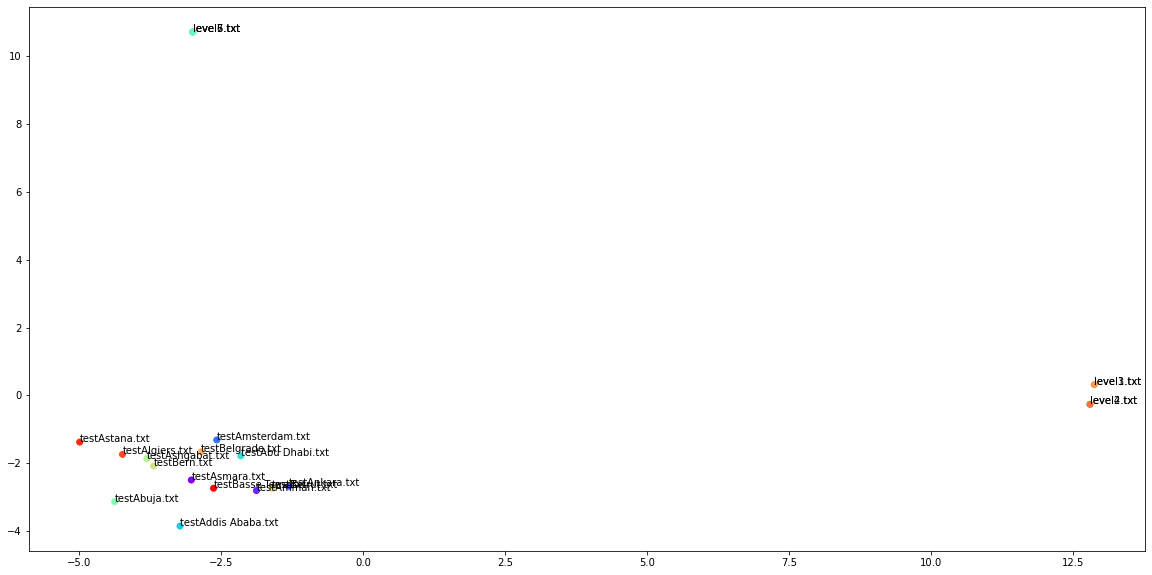

In [6]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=range(len(names)), cmap='rainbow')
for i, txt in enumerate(names):
    plt.annotate(txt, (X[:,0][i], X[:,1][i]))
    
plt.show()

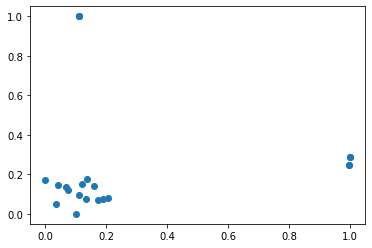

In [7]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
plt.scatter(X[:,0], X[:,1])
plt.show()

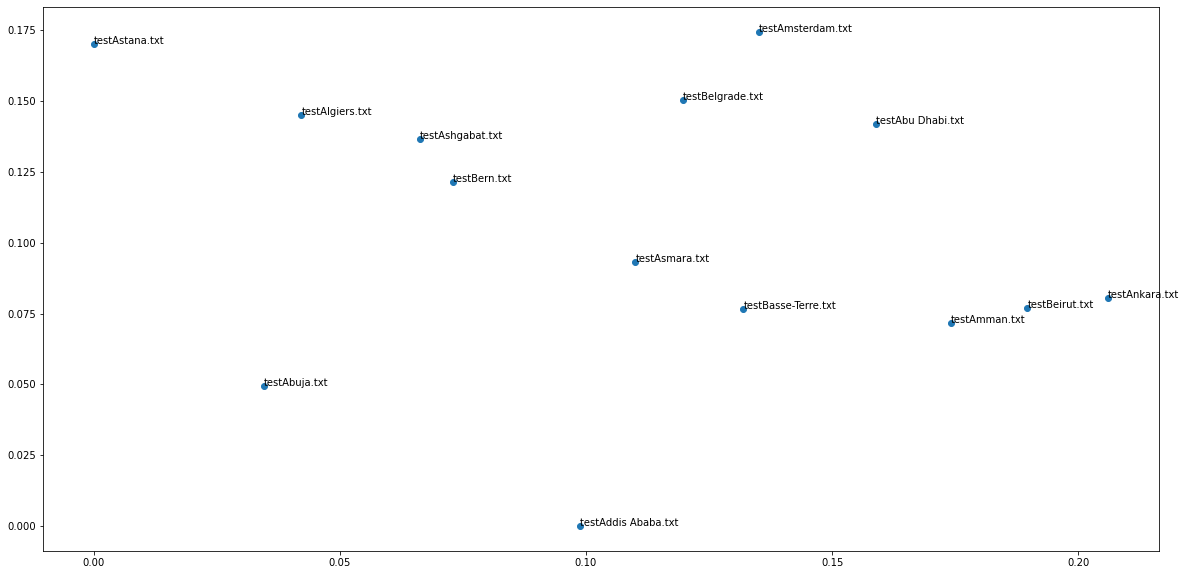

In [8]:
X_train = []
labels = []
for i, txt in enumerate(names):
    if txt.find('test') != -1:
        X_train.append(X[i])
        labels.append(txt)
        
X_train = np.array(X_train)

plt.figure(figsize=(20,10))
plt.scatter(X_train[:,0], X_train[:,1], cmap='rainbow')

for i, txt in enumerate(labels):
    plt.annotate(txt, (X_train[:,0][i], X_train[:,1][i]))
    
plt.show()

In [9]:
pca_data = 2*np.arcsin(np.sqrt(X_train))

In [10]:
dev = qml.device("default.qubit", wires= 2 * k + 1)
gen_dev = qml.device("default.qubit", wires=k)

In [11]:
def real(x_in_l):
#     qml.Rot(phi, theta, omega, wires=0)
    real_data_len = len(x_in_l)
    for i in range(real_data_len):
        qml.RY(x_in_l[i], wires= k + i)

In [12]:
def generator_sample(w):
    W = np.reshape(w, (layers, k))
    for h in range(len(W[0])):
        qml.Hadamard(wires=h)
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
        if i % 2 == 0:
            for l in range(1, len(W[i])):
                qml.CNOT(wires=[l-1, l])
            
def generator(w):
    W = np.reshape(w, (layers, k))
    for h in range(len(W[0])):
        qml.Hadamard(wires= k + h)
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires= k + j)
        if i % 2 == 0:
            for l in range(1, len(W[i])):
                qml.CNOT(wires=[k+(l-1), k + l])

In [13]:
def discriminator(w):
    W = np.reshape(w, (layers, k))
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
        if i == 0:
            for l in range(1, len(W[i])):
                qml.CNOT(wires=[l-1, l])

In [14]:
# For real data set
@qml.qnode(dev)
def real_disc_circuit(x_in_l, disc_weights):
    qml.Hadamard(wires= 2 * k)
    discriminator(disc_weights)
    real(x_in_l)
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
    return qml.expval(qml.PauliZ(2 * k))

# For Generated data set
@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    qml.Hadamard(wires= 2 * k)
    generator(gen_weights)
    discriminator(disc_weights)
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
    return qml.expval(qml.PauliZ(2 * k))

# Exract Synthetic data from Generator:
gen_dev.shots = 20
@qml.qnode(gen_dev)
def gen_data(gen_weights):
    generator_sample(gen_weights)
    exp = [qml.sample(qml.PauliZ(i)) for i in range(k)]
    return exp

In [15]:
def prob_real_true(x_in_l, disc_weights):
    true_disc_output = real_disc_circuit(x_in_l, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true  # generator wants to minimize this prob


def disc_cost(x_in_l, gen_weights, disc_weights):
    cost = 0
    for i in range(len(x_in_l)):
        cost += prob_fake_true(gen_weights, disc_weights) - prob_real_true(x_in_l[i], disc_weights)
#         cost += -1 * (np.log(1 - prob_fake_true(gen_weights, disc_weights)) + np.log(prob_real_true(x_in_l[i], disc_weights)))
    return cost / len(x_in_l)


def gen_cost(gen_weights, disc_weights):
    cost = 0
    for i in range(batch_size):
        cost += prob_fake_true(gen_weights, disc_weights)
#         cost += np.log(1 - prob_fake_true(gen_weights, disc_weights))
    return -(cost / batch_size)

In [16]:
layers = 4
eps = 1e-2
mulpt = 2
gen_weights = np.array([np.pi] + [0] * (layers * k - 1)) + np.random.normal(scale=eps, size=[layers * k])
disc_weights = np.random.normal(size=[k * layers])
drawer = qml.draw(real_disc_circuit, max_length=100)
print(drawer(pca_data[0], disc_weights))

  0: ──RY(0.649)───╭C───RY(-0.856)───RY(-0.289)───RY(0.808)───────────────╭SWAP────────────────────
  1: ──RY(-0.674)──╰X──╭C────────────RY(-0.239)───RY(-1.17)───RY(1.01)────│───────────────────╭SWAP
  2: ──RY(-0.449)──────╰X───────────╭C────────────RY(0.412)───RY(-0.702)──│───────RY(-0.143)──│────
  3: ──RY(1.19)─────────────────────╰X───────────╭C───────────RY(0.116)───│───────RY(0.826)───│────
  4: ──RY(-0.124)────────────────────────────────╰X──────────╭C───────────│───────RY(0.554)───│────
  5: ──RY(-0.726)────────────────────────────────────────────╰X───────────│──────╭C───────────│────
  6: ──RY(0.336)──────────────────────────────────────────────────────────│──────╰X───────────│────
  7: ──RY(0.676)──────────────────────────────────────────────────────────├SWAP───────────────│────
  8: ──RY(0.621)──────────────────────────────────────────────────────────│───────────────────├SWAP
  9: ──RY(1.81)───────────────────────────────────────────────────────────│───────────────────│────


In [17]:
opt = MomentumOptimizer(0.09)

Starting Epoch :  0
Step 1: cost = -0.0059527874698776335
Step 4: cost = -0.001128175050978249
Step 7: cost = -0.0042198994541824035
Step 10: cost = -6.800911945481491e-05
Step 13: cost = -0.00021400364798540572
Checking output : P(Real == True) : 0.5000317014167248
Checking output : P(Gen == True) : 0.5000272973514038
Generator Training starting......
Step 1: cost = -0.5000274348696667
Step 4: cost = -0.5000276974951386
Step 7: cost = -0.5000280751743724
Step 10: cost = -0.5000285597899982
Step 13: cost = -0.5000291448265592
Checking output : P(Real == True) : 0.5000001983027167
Checking output : P(Gen == True) : 0.5000291448265592
Disc Cost =  -6.613072403342339e-05


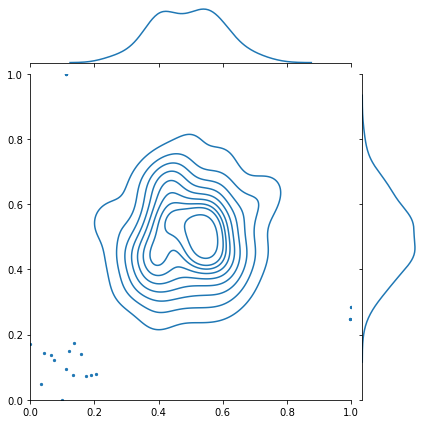

Starting Epoch :  1
Step 1: cost = -0.003172923020402877
Step 4: cost = -0.009855745713724126
Step 7: cost = -0.005869794578172494
Step 10: cost = -0.005134028754618695
Step 13: cost = -0.0008166465924565047
Checking output : P(Real == True) : 0.5060487756875939
Checking output : P(Gen == True) : 0.5000795011560006
Generator Training starting......
Step 1: cost = -0.5000808579416748
Step 4: cost = -0.5000825395675366
Step 7: cost = -0.5000845294599534
Step 10: cost = -0.5000868150042863
Step 13: cost = -0.5000893869393888
Checking output : P(Real == True) : 0.5128994874015703
Checking output : P(Gen == True) : 0.5000893869393888
Disc Cost =  -0.010526529890856081


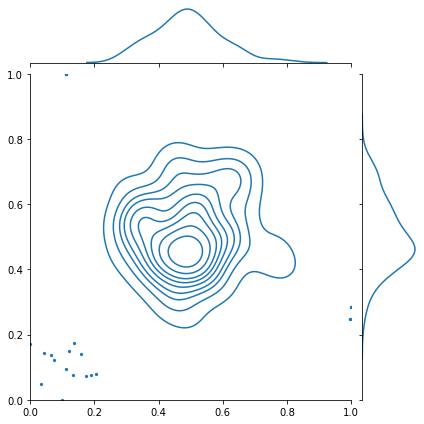

Starting Epoch :  2
Step 1: cost = -0.00422078781719019
Step 4: cost = -0.004563339677836509
Step 7: cost = -0.011115086232537022
Step 10: cost = -0.014282325013160438
Step 13: cost = -0.010616082141375605
Checking output : P(Real == True) : 0.5093948299913156
Checking output : P(Gen == True) : 0.5002879932009328
Generator Training starting......
Step 1: cost = -0.5002943236828806
Step 4: cost = -0.5003019855773184
Step 7: cost = -0.5003109319834717
Step 10: cost = -0.5003211324327393
Step 13: cost = -0.5003325706291876
Checking output : P(Real == True) : 0.5093948299913156
Checking output : P(Gen == True) : 0.5003325706291876
Disc Cost =  -0.016128240152531375


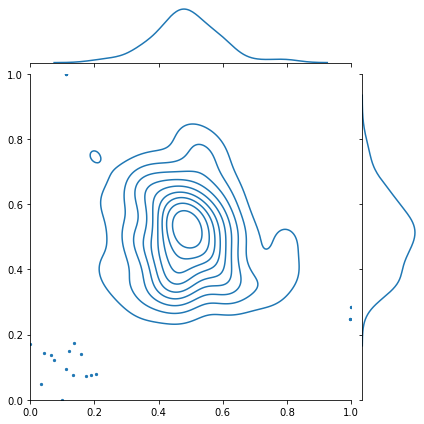

Starting Epoch :  3
Step 1: cost = -0.006536121551255565
Step 4: cost = -0.011242054113049238
Step 7: cost = -0.012803992103126549
Step 10: cost = -0.008851697739899281
Step 13: cost = -0.025278237868693543
Checking output : P(Real == True) : 0.5023949582532417
Checking output : P(Gen == True) : 0.5010887430536904
Generator Training starting......
Step 1: cost = -0.501118128925194
Step 4: cost = -0.5011540096157749
Step 7: cost = -0.5011962821872058
Step 10: cost = -0.5012449386986664
Step 13: cost = -0.5013000561555381
Checking output : P(Real == True) : 0.5023949582532417
Checking output : P(Gen == True) : 0.5013000561555381
Disc Cost =  -0.009085576320751021


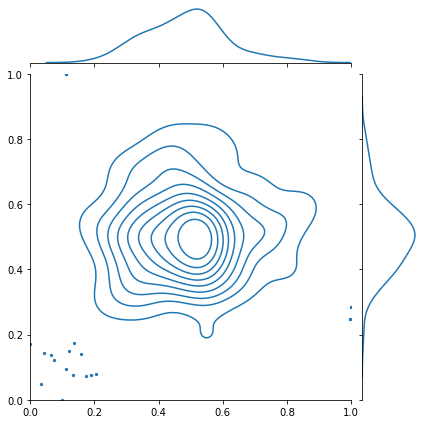

Starting Epoch :  4
Step 1: cost = -0.011703654407106412
Step 4: cost = -0.021161732154699076
Step 7: cost = -0.024685776316693442
Step 10: cost = -0.03010525802260718
Step 13: cost = -0.03410211415619746
Checking output : P(Real == True) : 0.5380675448228913
Checking output : P(Gen == True) : 0.5039654306666939
Generator Training starting......
Step 1: cost = -0.5041072006389353
Step 4: cost = -0.5042831549877715
Step 7: cost = -0.5044939131049306
Step 10: cost = -0.5047407850774764
Step 13: cost = -0.5050257474474256
Checking output : P(Real == True) : 0.5380675448228913
Checking output : P(Gen == True) : 0.5050257474474256
Disc Cost =  -0.03304179737546575


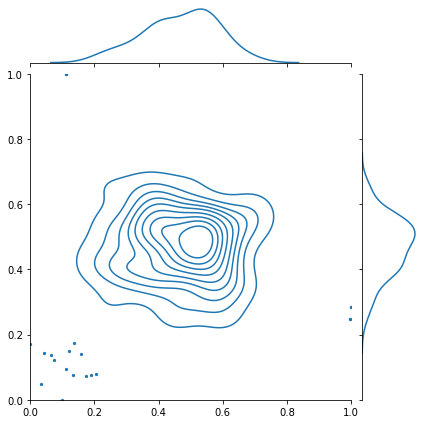

Starting Epoch :  5
Step 1: cost = -0.039452640735330835
Step 4: cost = -0.028818420396850897
Step 7: cost = -0.05626392327489238
Step 10: cost = -0.06819071853932401
Step 13: cost = -0.0832835748230788
Checking output : P(Real == True) : 0.5953139817116855
Checking output : P(Gen == True) : 0.5120304068886067
Generator Training starting......
Step 1: cost = -0.5126721789627624
Step 4: cost = -0.5134779692559317
Step 7: cost = -0.5144596556847821
Step 10: cost = -0.5156340228173807
Step 13: cost = -0.5170230653920017
Checking output : P(Real == True) : 0.5953139817116855
Checking output : P(Gen == True) : 0.5170230653920017
Disc Cost =  -0.07829091631968377


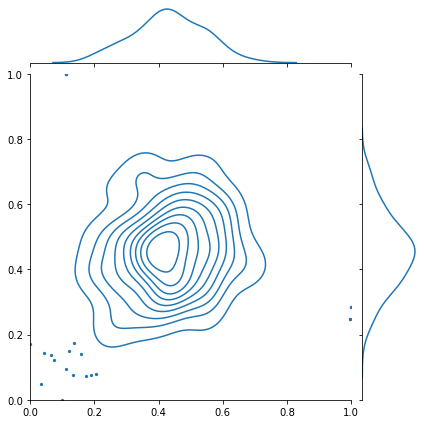

Starting Epoch :  6
Step 1: cost = -0.09677723422005269
Step 4: cost = -0.11989298338386101
Step 7: cost = -0.14824853495302226
Step 10: cost = -0.1819689876555005
Step 13: cost = -0.22025773817114858
Checking output : P(Real == True) : 0.7438781930102807
Checking output : P(Gen == True) : 0.5236204548391321
Generator Training starting......
Step 1: cost = -0.5258116278657565
Step 4: cost = -0.528556377624507
Step 7: cost = -0.5319329517734136
Step 10: cost = -0.5360402913557936
Step 13: cost = -0.5409997730484193
Checking output : P(Real == True) : 0.7438781930102807
Checking output : P(Gen == True) : 0.5409997730484193
Disc Cost =  -0.2028784199618614


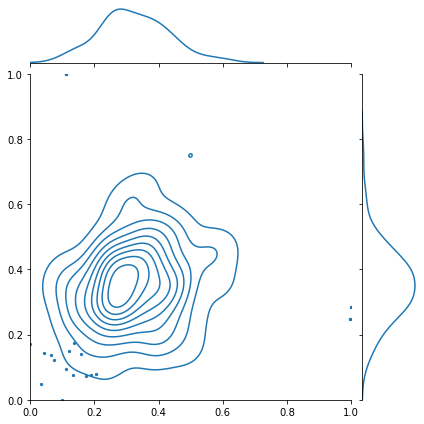

Starting Epoch :  7
Step 1: cost = -0.2438199496418958
Step 4: cost = -0.2839515177517302
Step 7: cost = -0.3188077822595812
Step 10: cost = -0.3448536235837958
Step 13: cost = -0.36098843951413595
Checking output : P(Real == True) : 0.8832015032668592
Checking output : P(Gen == True) : 0.5222130637527232
Generator Training starting......
Step 1: cost = -0.5262801640200855
Step 4: cost = -0.5312168846885672
Step 7: cost = -0.537212629112248
Step 10: cost = -0.5444921275475775
Step 13: cost = -0.5533166147720394
Checking output : P(Real == True) : 0.8832015032668592
Checking output : P(Gen == True) : 0.5533166147720394
Disc Cost =  -0.3298848884948198


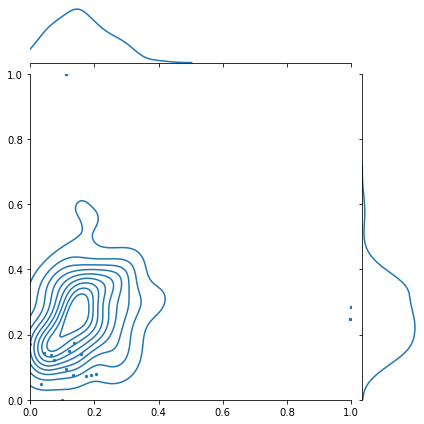

Starting Epoch :  8
Step 1: cost = -0.3392140463493494
Step 4: cost = -0.34169302060261075
Step 7: cost = -0.3407466335757768
Step 10: cost = -0.3394833679804703
Step 13: cost = -0.33997729581699043
Checking output : P(Real == True) : 0.8745632741350418
Checking output : P(Gen == True) : 0.5345859783180513
Generator Training starting......
Step 1: cost = -0.543443857007413
Step 4: cost = -0.5543968503445977
Step 7: cost = -0.567886280510095
Step 10: cost = -0.5843734881223491
Step 13: cost = -0.604281998951543
Checking output : P(Real == True) : 0.8745632741350418
Checking output : P(Gen == True) : 0.604281998951543
Disc Cost =  -0.27028127518349876


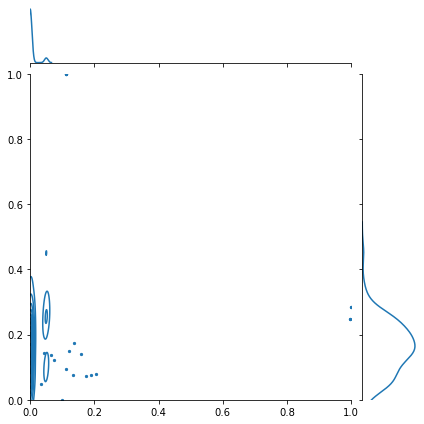

Starting Epoch :  9
Step 1: cost = -0.27054268826370353
Step 4: cost = -0.27238671281204374
Step 7: cost = -0.27581694580645766
Step 10: cost = -0.28054799629151894
Step 13: cost = -0.28609251675940295
Checking output : P(Real == True) : 0.8942221195793318
Checking output : P(Gen == True) : 0.6081296028199289
Generator Training starting......
Step 1: cost = -0.6322433687916962
Step 4: cost = -0.660206749647104
Step 7: cost = -0.6915452406821084
Step 10: cost = -0.7251409598788486
Step 13: cost = -0.7592256909986675
Checking output : P(Real == True) : 0.8942221195793318
Checking output : P(Gen == True) : 0.7592256909986677
Disc Cost =  -0.13499642858066419


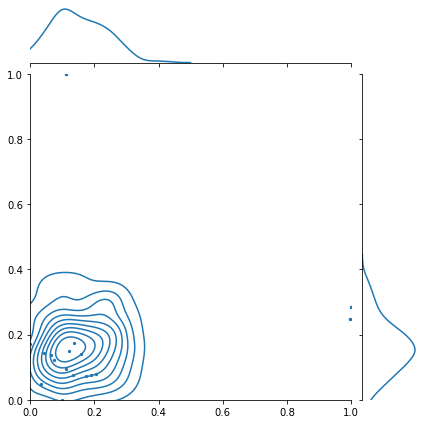

Starting Epoch :  10
Step 1: cost = -0.14697420303389075
Step 4: cost = -0.16155204664751566
Step 7: cost = -0.17632946991715615
Step 10: cost = -0.18889645337774486
Step 13: cost = -0.1974939464100438
Checking output : P(Real == True) : 0.8570691836009191
Checking output : P(Gen == True) : 0.6595752371908753
Generator Training starting......
Step 1: cost = -0.6827270134527934
Step 4: cost = -0.7055543759125502
Step 7: cost = -0.7278770130424016
Step 10: cost = -0.7499311819191465
Step 13: cost = -0.7723581686940939
Checking output : P(Real == True) : 0.8570691836009191
Checking output : P(Gen == True) : 0.7723581686940939
Disc Cost =  -0.0847110149068252


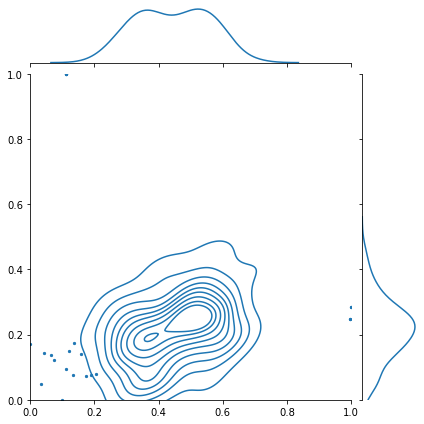

Starting Epoch :  11
Step 1: cost = -0.09766064591299595
Step 4: cost = -0.10841363196305864
Step 7: cost = -0.11658409853682816
Step 10: cost = -0.12256969983825905
Step 13: cost = -0.1272100158583409
Checking output : P(Real == True) : 0.767358378513447
Checking output : P(Gen == True) : 0.6401483626551061
Generator Training starting......
Step 1: cost = -0.6564071224365475
Step 4: cost = -0.6762997177574062
Step 7: cost = -0.7012159487432147
Step 10: cost = -0.7321567776927892
Step 13: cost = -0.7692922296453591
Checking output : P(Real == True) : 0.767358378513447
Checking output : P(Gen == True) : 0.7692922296453591
Disc Cost =  0.0019338511319121343


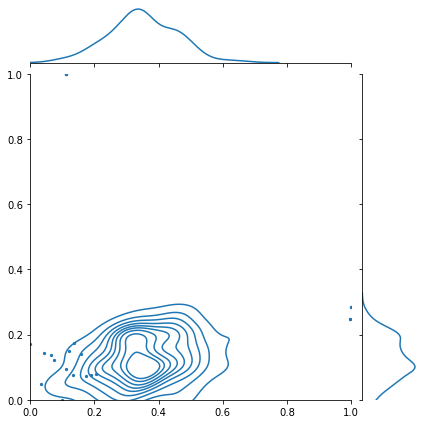

Starting Epoch :  12
Step 1: cost = -0.012143036425713682
Step 4: cost = -0.027984139049975543
Step 7: cost = -0.04499240840117191
Step 10: cost = -0.062357934729384445
Step 13: cost = -0.07905611738792684
Checking output : P(Real == True) : 0.73673793472993
Checking output : P(Gen == True) : 0.6576818173420031
Generator Training starting......
Step 1: cost = -0.6942868323205018
Step 4: cost = -0.7398458078667258
Step 7: cost = -0.7914750544077175
Step 10: cost = -0.8432003758874447
Step 13: cost = -0.8870910450290972
Checking output : P(Real == True) : 0.73673793472993
Checking output : P(Gen == True) : 0.8870910450290972
Disc Cost =  0.1503531102991672


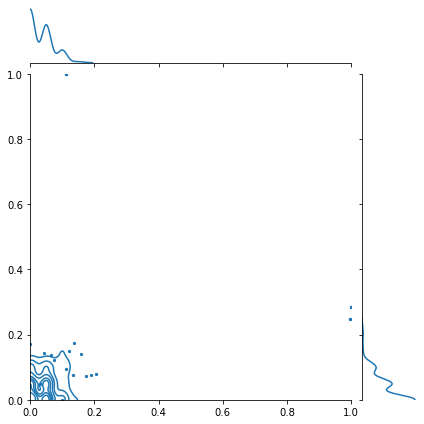

Starting Epoch :  13
Step 1: cost = 0.13024128507927724
Step 4: cost = 0.10631706740203262
Step 7: cost = 0.07993394664393982
Step 10: cost = 0.05265588629304496
Step 13: cost = 0.026126029813901663
Checking output : P(Real == True) : 0.6927961894268296
Checking output : P(Gen == True) : 0.7189222192407313
Generator Training starting......
Step 1: cost = -0.7469784721790752
Step 4: cost = -0.7669187486892112
Step 7: cost = -0.7786279218079045
Step 10: cost = -0.7840138492609393
Step 13: cost = -0.7860869526269095
Checking output : P(Real == True) : 0.6927961894268296
Checking output : P(Gen == True) : 0.7860869526269096
Disc Cost =  0.09329076320008


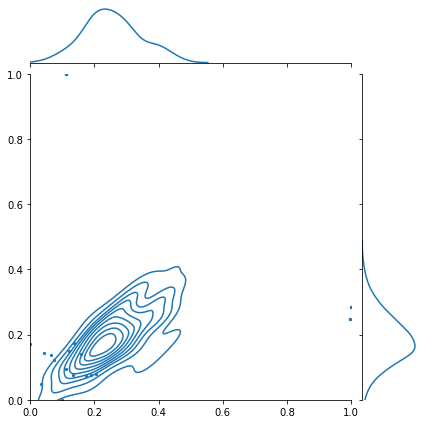

Starting Epoch :  14
Step 1: cost = 0.0478049584904251
Step 4: cost = -0.006328694515406297
Step 7: cost = -0.05756035359756062
Step 10: cost = -0.09395778291465595
Step 13: cost = -0.1092346891104844
Checking output : P(Real == True) : 0.632142879956638
Checking output : P(Gen == True) : 0.5229081908461536
Generator Training starting......
Step 1: cost = -0.5217902536081009
Step 4: cost = -0.5211099158729127
Step 7: cost = -0.5208253261168878
Step 10: cost = -0.5208927977095206
Step 13: cost = -0.5212810513893356
Checking output : P(Real == True) : 0.632142879956638
Checking output : P(Gen == True) : 0.5212810513893356
Disc Cost =  -0.11086182856730242


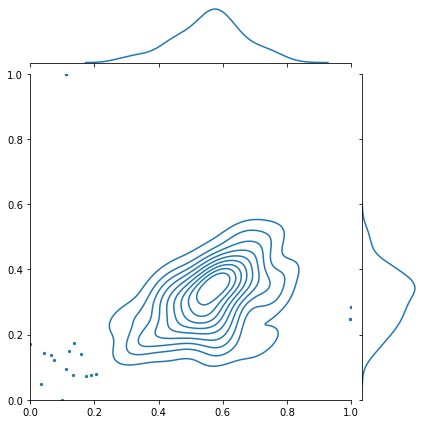

Starting Epoch :  15
Step 1: cost = -0.10686412735013029
Step 4: cost = -0.09589755188958149
Step 7: cost = -0.08623068652641908
Step 10: cost = -0.08256169287948312
Step 13: cost = -0.08690670640296383
Checking output : P(Real == True) : 0.5871441156225743
Checking output : P(Gen == True) : 0.5002374092196105
Generator Training starting......
Step 1: cost = -0.5001205595674216
Step 4: cost = -0.500056062657775
Step 7: cost = -0.5000225657301365
Step 10: cost = -0.5000068664480091
Step 13: cost = -0.5000009540648258
Checking output : P(Real == True) : 0.5871441156225743
Checking output : P(Gen == True) : 0.5000009540648258
Disc Cost =  -0.08714316155774848


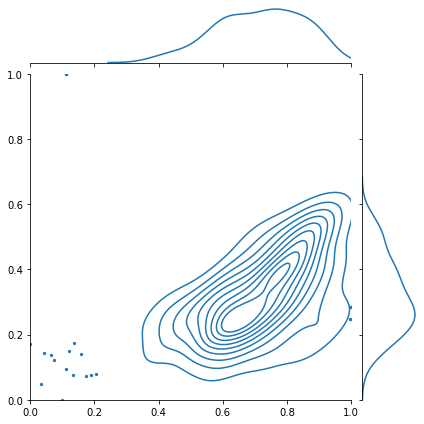

Starting Epoch :  16
Step 1: cost = -0.10012644819857575
Step 4: cost = -0.1235905613646382
Step 7: cost = -0.1599913642420535
Step 10: cost = -0.2113323976113637
Step 13: cost = -0.27675444063603993
Checking output : P(Real == True) : 0.776933973364403
Checking output : P(Gen == True) : 0.500179532728363
Generator Training starting......
Step 1: cost = -0.5000394922202034
Step 4: cost = -0.500000043802484
Step 7: cost = -0.500038097871801
Step 10: cost = -0.5001367326630588
Step 13: cost = -0.5002841304161757
Checking output : P(Real == True) : 0.776933973364403
Checking output : P(Gen == True) : 0.5002841304161757
Disc Cost =  -0.27664984294822725


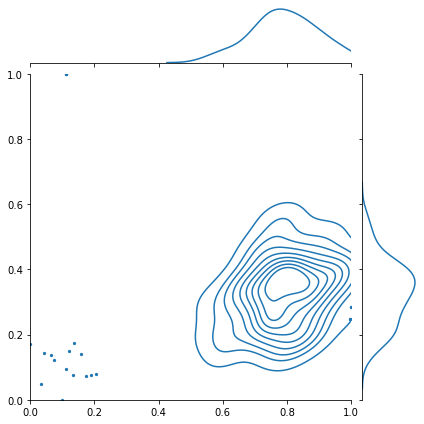

Starting Epoch :  17
Step 1: cost = -0.3482058700707363
Step 4: cost = -0.41250702118484933
Step 7: cost = -0.4547236053126101
Step 10: cost = -0.46787481675932296
Step 13: cost = -0.4568102379662058
Checking output : P(Real == True) : 0.9612209811885146
Checking output : P(Gen == True) : 0.5044107432223088
Generator Training starting......
Step 1: cost = -0.506307649755199
Step 4: cost = -0.5089743769140067
Step 7: cost = -0.5127088957104184
Step 10: cost = -0.5179123509239216
Step 13: cost = -0.5251143837519712
Checking output : P(Real == True) : 0.9612209811885146
Checking output : P(Gen == True) : 0.5251143837519712
Disc Cost =  -0.43610659743654345


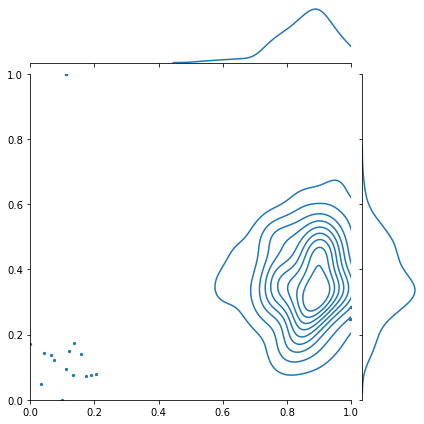

Starting Epoch :  18
Step 1: cost = -0.4174938062382679
Step 4: cost = -0.4002889786847976
Step 7: cost = -0.3901233871766279
Step 10: cost = -0.38931729953585653
Step 13: cost = -0.39769201377691155
Checking output : P(Real == True) : 0.8985344747908051
Checking output : P(Gen == True) : 0.5008424610138935
Generator Training starting......
Step 1: cost = -0.5026305707819165
Step 4: cost = -0.5053372869838348
Step 7: cost = -0.5090512104657138
Step 10: cost = -0.5139746018437785
Step 13: cost = -0.5204099758266891
Checking output : P(Real == True) : 0.8985344747908051
Checking output : P(Gen == True) : 0.5204099758266891
Disc Cost =  -0.37812449896411593


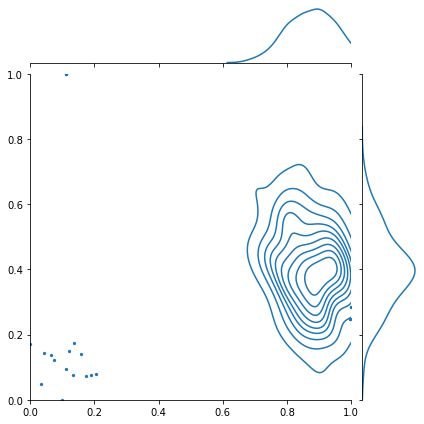

Starting Epoch :  19
Step 1: cost = -0.3982027624701532
Step 4: cost = -0.4195787149914727
Step 7: cost = -0.4380179627886654
Step 10: cost = -0.450620895642462
Step 13: cost = -0.45649045221049944
Checking output : P(Real == True) : 0.9601539416660331
Checking output : P(Gen == True) : 0.5036634894555336
Generator Training starting......
Step 1: cost = -0.5069535519962276
Step 4: cost = -0.5112929305309388
Step 7: cost = -0.5168333081501746
Step 10: cost = -0.5238042246124262
Step 13: cost = -0.5324994884258494
Checking output : P(Real == True) : 0.9601539416660331
Checking output : P(Gen == True) : 0.5324994884258494
Disc Cost =  -0.42765445324018375


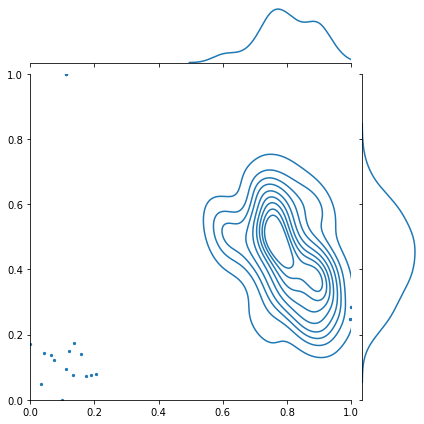

In [18]:
# trainin cycle loop:
# dev.shots = 10
# learning_rate = 0.1
batch_size = 3
generator_cost = []
dis_cost = []
epochs = 20
for ep in range(epochs):
    print("Starting Epoch : ", ep)
    
    # Train the discriminator first, lock the generator variables:
    disc_weights.requires_grad = True
    gen_weights.requires_grad = False
    for i in range(0, len(pca_data), batch_size):
        if i + batch_size >= len(pca_data):
            x_in_l = np.array(pca_data[i: len(pca_data)], requires_grad=False)
        else:
            x_in_l = np.array(pca_data[i: i+batch_size], requires_grad=False)
            
        x_in_l, gen_weights, disc_weights = opt.step(disc_cost, x_in_l, gen_weights, disc_weights)
        cost = disc_cost(x_in_l, gen_weights, disc_weights)
        dis_cost.append(cost)
        print("Step {}: cost = {}".format(i + 1, cost))
#     for i in range(len(pca_data)):
#         x_in_l = np.array(pca_data[i], requires_grad=False)
#         x_in_l, gen_weights, disc_weights = opt.step(disc_cost, x_in_l, gen_weights, disc_weights)
#         cost = disc_cost(x_in_l,gen_weights, disc_weights)
#         if i % batch_size == 0:
            
#             print("Step {}: cost = {}".format(i + 1, cost))
    test_ind = random.randrange(len(pca_data) - batch_size)        
    test_x = pca_data[test_ind: test_ind + batch_size]
    print("Checking output : P(Real == True) :", prob_real_true(test_x[random.randrange(len(test_x))], disc_weights))
    print("Checking output : P(Gen == True) :", prob_fake_true(gen_weights, disc_weights))
    
    print("Generator Training starting......")
    # Train the Generator next, lock the discriminator variables:
    disc_weights.requires_grad = False
    gen_weights.requires_grad = True   
    for j in range(0, len(pca_data), batch_size):
        gen_weights, disc_weights = opt.step(gen_cost, gen_weights, disc_weights)
#         gradient = qml.gradients.param_shift(gen_disc_circuit)(gen_weights, disc_weights)
#         gen_weights = update_weights(gen_weights, learning_rate, gradient, True)
        cost = gen_cost(gen_weights, disc_weights)
        generator_cost.append(cost)
#         if i % batch_size == 0:
        print("Step {}: cost = {}".format(j + 1, cost))
            
    print("Checking output : P(Real == True) :", prob_real_true(test_x[random.randrange(len(test_x))], disc_weights))
    print("Checking output : P(Gen == True) :", prob_fake_true(gen_weights, disc_weights))
    print("Disc Cost = ", disc_cost(test_x, gen_weights, disc_weights))
    # generate distribution graph
    gen_datas = []
    for _ in range(100):
        res = gen_data(gen_weights)
        result = []
        for i in range(len(res)): 
            result.append(res[i].tolist().count(-1) / len(res[i].tolist()))
        gen_datas.append(result)
    
    # Shuffle Input data    
    random.shuffle(pca_data)
    
    generated_data = np.array(gen_datas)
    graph = sns.jointplot(x=generated_data[:,0],y=generated_data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
    graph.x = X[:,0]
    graph.y = X[:,1]
    graph.plot_joint(plt.scatter, marker='o', s=5)
    plt.show()

In [19]:
# Exract Synthetic data from Generator:
gen_dev.shots= 20
gen_datas = []
for _ in range(11):
    res = gen_data(gen_weights)
    result = []
    for i in range(len(res)): 
        result.append(res[i].tolist().count(-1) / len(res[i].tolist()))
    print(result)
    gen_datas.append(result)

[0.6, 0.6, 0.45, 0.15, 0.65, 0.7, 0.8]
[0.85, 0.4, 0.35, 0.5, 0.45, 0.7, 0.85]
[0.65, 0.45, 0.55, 0.3, 0.55, 0.55, 0.7]
[0.85, 0.4, 0.45, 0.6, 0.65, 0.8, 0.85]
[0.7, 0.6, 0.55, 0.3, 0.65, 0.55, 0.85]
[0.8, 0.45, 0.4, 0.4, 0.7, 0.7, 0.75]
[0.8, 0.5, 0.15, 0.6, 0.55, 0.6, 0.8]
[0.75, 0.45, 0.35, 0.3, 0.6, 0.6, 0.7]
[0.95, 0.4, 0.4, 0.4, 0.7, 0.55, 0.85]
[0.75, 0.45, 0.45, 0.45, 0.5, 0.7, 0.55]
[0.8, 0.35, 0.35, 0.1, 0.7, 0.45, 0.75]


In [20]:
synthetic_points = scaler.inverse_transform(np.array(gen_datas))
synthetic_map = pca.inverse_transform(synthetic_points)

In [21]:
i = 0
for map1 in synthetic_map:
    map1 = np.reshape(map1, shape)
    map_new  = ""
    for m in map1:
        for l in m:
            if l > 0.5:
                map_new +="#"
            else:
                map_new += "."
        map_new += "\n"

    newLoc = "./resource/generated_maps/test_V_" + str(i) + ".txt"
    text_file = open(newLoc , "w")
    text_file.write(map_new)
    text_file.close()
    i += 1

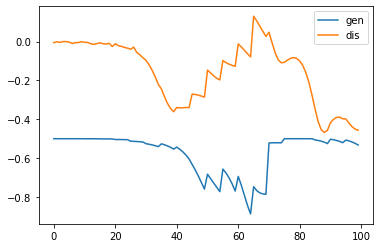

In [22]:
plt.plot(range(len(generator_cost)), generator_cost, label='gen')
plt.plot(range(len(dis_cost)), dis_cost, label='dis')
plt.legend()
plt.show()